In [1]:
import numpy as np
import json
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict
import math
from itertools import combinations

plt.rcParams['figure.figsize'] = [16, 4]
from plot_utils import *

In [2]:
def plot_mouli_te_variation_with_pval(ax,run_list,pval_list,main_enum,plot_item_list,fname_pattern,title,label_prefix=""):
    #Getting the result dict
    result_dict_erm = get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=fname_pattern+"probe_metric_list_erm.json",
    )
    result_dict_cad = get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=fname_pattern+"probe_metric_list_cad.json",
    )
    
    
    #Getting the mouli's tv estimate of the TE
    avg_mouli_tv_pred = get_avg_tv_pred(
            run_list=run_list,
            pval_list=pval_list,
            tv_fname_pattern = fname_pattern+"mouli_pred_tv_data.json"
    )
    
    #Plotting the correlation
    offset_sub=1
    if "nlp_toy3" in fname_pattern:
        offset_sub=0
        correlation_items = ["y-tcausal","y-tconfound","y-tspurious",]
        for corr_item in correlation_items:
            corr_val_mean = np.array([result_dict_erm[pval][corr_item]["mean"] for pval in pval_list])
            corr_val_std = np.array([result_dict_erm[pval][corr_item]["std"] for pval in pval_list])
            ax[0].plot(pval_list,corr_val_mean,ls="-.",marker="o",label=label_prefix+corr_item,alpha=0.7)
            ax[0].fill_between(pval_list,corr_val_mean-corr_val_std,corr_val_mean+corr_val_std,alpha=0.3)
            ax[0].set_xlabel("pval")
            ax[0].set_ylim(0.0,1.0)
            ax[0].set_ylabel("topic correlation")
            ax[0].grid(True)
            ax[0].legend()
            ax[0].set_title(title)
            
    
    #plotting the avg mouli tv
    tv_pval_var_mean = np.array([avg_mouli_tv_pred[pval]["mean"] for pval in pval_list])
    tv_pval_var_std = np.array([avg_mouli_tv_pred[pval]["std"] for pval in pval_list])
    ax[1-offset_sub].plot(pval_list,tv_pval_var_mean,ls="-.",marker="o",alpha=0.7,label=label_prefix)
    ax[1-offset_sub].fill_between(pval_list,tv_pval_var_mean-tv_pval_var_std,tv_pval_var_mean+tv_pval_var_std,alpha=0.3)
    ax[1-offset_sub].set_xlabel("pval")
#     ax[1].set_ylim(0.0,1.0)
    ax[1-offset_sub].set_ylabel("|P(Y|phi(X)) - P(Y|X)|")
    ax[1-offset_sub].grid(True)
    ax[1-offset_sub].set_title(title)
    ax[1-offset_sub].legend()
    
    
    #Plotting the rest the items
    for pidx,plot_item in enumerate(plot_item_list):
        #Plotting the results
        item_yval_erm = np.array([result_dict_erm[pval][plot_item]["mean"] for pval in pval_list])
        yerr_erm = np.array([result_dict_erm[pval][plot_item]["std"] for pval in pval_list])
        #Plotting the item
        ax[pidx+2-offset_sub].plot(pval_list,item_yval_erm,label=label_prefix+"erm",ls="-.",marker="o",alpha=0.7)
        ax[pidx+2-offset_sub].fill_between(pval_list,item_yval_erm-yerr_erm,item_yval_erm+yerr_erm,alpha=0.3)
        
        #Plotting the results
        item_yval_cad = np.array([result_dict_cad[pval][plot_item]["mean"] for pval in pval_list])
        yerr_cad = np.array([result_dict_cad[pval][plot_item]["std"] for pval in pval_list])
        #Plotting the item
        ax[pidx+2-offset_sub].plot(pval_list,item_yval_cad,label=label_prefix+"cad",ls="-.",marker="o",alpha=0.7)
        ax[pidx+2-offset_sub].fill_between(pval_list,item_yval_cad-yerr_cad,item_yval_cad+yerr_cad,alpha=0.3)
        
        
        ax[pidx+2-offset_sub].set_xlabel("pval")
        #ax[pidx+2-offset_sub].set_ylim(-0.3,0.3)
        ax[pidx+2-offset_sub].set_ylabel(plot_item)
        ax[pidx+2-offset_sub].legend()
        ax[pidx+2-offset_sub].grid(True)
        ax[pidx+2-offset_sub].set_title(title)

In [3]:
def plot_mouli_selection_metrics(ax,run_list,topic_list,pval_list,main_enum,mouli_plot_item_list,probe_plot_item_list,fname_pattern):
    avg_mouli_selec_metric_dict = {}
    all_result_dict = {}
    #First of all getting the erm (no invariance results)
    avg_mouli_selec_metric_erm = get_avg_tv_pred(run_list= run_list,
                                             pval_list=pval_list,
                                             tv_fname_pattern=fname_pattern+"mouli_erm_data.json",
                                             item_list=mouli_plot_item_list,
    )
    avg_mouli_selec_metric_dict[()] = avg_mouli_selec_metric_erm
    #Loading the result dict for this run
    result_dict_erm = get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=fname_pattern+"probe_metric_list_erm.json",
    )
    all_result_dict[()] = result_dict_erm
#     print(result_dict_erm)
    
    
    #Going over all the topic subset and plotting the metric
    for sidx in range(1,len(topic_list)+1):
        for topic_subset in combinations(topic_list,sidx):
            avg_mouli_selec_metric_dict[sort_topic_tuple(topic_subset)] = get_avg_tv_pred(
                                     run_list= run_list,
                                     pval_list=pval_list,
                                     tv_fname_pattern=fname_pattern+"mouli_({})_data.json".format(",".join(topic_subset)),
                                     item_list=mouli_plot_item_list,
            )
            
            all_result_dict[sort_topic_tuple(topic_subset)]= get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=fname_pattern+"probe_metric_list_({})_cad.json".format("".join(topic_subset)),
    )
#     print(all_result_dict[()][0.5])
    
    #Merging the dict
    for model in all_result_dict.keys():
        for pval in all_result_dict[model].keys():
            for item in all_result_dict[model][pval].keys():
                avg_mouli_selec_metric_dict[model][pval][item] = all_result_dict[model][pval][item]

    
    #Generating the comnined score for every model
    for model in avg_mouli_selec_metric_dict.keys():
        for pval in pval_list:
            mouli_score = get_model_mouli_score(topic_list,avg_mouli_selec_metric_dict,model,pval)
            avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["mean"]=mouli_score
            avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["std"]=0.0
    
    #Now we will plot one by one for all the plot items for all the invariant models
    for inv_model,avg_mouli_selec_metric in avg_mouli_selec_metric_dict.items():
        for pidx,plot_item in enumerate(mouli_plot_item_list+probe_plot_item_list):
            #Plotting the results
            item_yval = np.array([avg_mouli_selec_metric[pval][plot_item]["mean"] for pval in pval_list])
            yerr = np.array([avg_mouli_selec_metric[pval][plot_item]["std"] for pval in pval_list])
            #Plotting the item
            label = ",".join(inv_model) if len(inv_model)!=0 else "erm"
            ax[pidx].plot(pval_list,item_yval,label=label,ls="-.",marker="o",alpha=0.7)
            ax[pidx].fill_between(pval_list,item_yval-yerr,item_yval+yerr,alpha=0.3)
            
            
            ax[pidx].set_xlabel("pval")
            #ax[pidx+2-offset_sub].set_ylim(-0.3,0.3)
            ax[pidx].set_ylabel(plot_item)
            ax[pidx].legend()
            ax[pidx].grid(True)
            #ax[pidx].set_title(title)
    
    return avg_mouli_selec_metric_dict

In [4]:
def read_tv_json_file(tv_fname):
    with open(tv_fname,"r") as rhandle:
        pred_tv_data = json.load(rhandle)
    return pred_tv_data

def get_avg_tv_pred(run_list,pval_list,tv_fname_pattern,item_list):
    avg_tv_pval_dict = defaultdict(dict)
    #Going over the pval
    for pval in pval_list:
        #Going over the runs to get the average
        for item_name in item_list:
            avg_tv_pval_dict[pval][item_name]={}
            avg_tv_pval_dict[pval][item_name]["val_list"]=[]
            if item_name=="mouli_score":
                continue
            
            for rnum in run_list:
                pred_tv_data = read_tv_json_file(
                                            tv_fname_pattern.format(pval,rnum)
                )
                avg_tv_pval_dict[pval][item_name]["val_list"].append(pred_tv_data[item_name])
            #Getting the avarge over the pval
            avg_tv_pval_dict[pval][item_name]["mean"]=np.mean(avg_tv_pval_dict[pval][item_name]["val_list"])
            avg_tv_pval_dict[pval][item_name]["std"]=np.std(avg_tv_pval_dict[pval][item_name]["val_list"])
        
    return avg_tv_pval_dict

In [5]:
def sort_topic_tuple(topic_tuple):
    topic_list = list(topic_tuple)
    topic_list.sort()
    return tuple(topic_list)

def get_topic_complement(topic_tuple,all_topic_list):
    topic_set = set(topic_tuple)
    all_topic_set = set(all_topic_list)
    
    return sort_topic_tuple(all_topic_set - topic_set)

In [6]:
def get_model_mouli_score(topic_list,avg_mouli_selec_metric,model,pval):
    '''
    '''    
    model_mouli_score = avg_mouli_selec_metric[model][pval]["best_train_main_metric"]["mean"]\
                        - avg_mouli_selec_metric[model][pval]["best_train_main_random_metric"]["mean"]\
                        + 2**(len(topic_list)-len(model))-1
    return model_mouli_score


def ges_minimize(pval,topic_list,avg_mouli_selec_metric_dict):
    '''
    Here we will implement the GES for selecting edge in the Mouli's graph.
    Since large part of the graph is already made, the only thig we have to decide is
    whether there is an arrow from  topic --> Y. 
    
    There cannot be reverse arrow since it will create cycle :  Y --> topic --> X --> X_dagger
    '''
    edge_list = []
    #Forward phase
    model = get_topic_complement((),topic_list)
    min_score = get_model_mouli_score(topic_list,avg_mouli_selec_metric_dict,model,pval)
    print("Initial Edge List:{}, initial score:{}".format(edge_list,min_score))
    print("Starting the addition phase")
    while True:
        #Adding the edge one by one to see if furthur edge addition is possible or not
        new_topic = None
        new_topic_score = float("inf")
        
        for topic in topic_list:
            #If edge is already there
            if topic in edge_list:
                continue
            #Now lets check if adding this
            model = get_topic_complement(sort_topic_tuple(edge_list+[topic]),topic_list)
            added_new_score = get_model_mouli_score(topic_list,avg_mouli_selec_metric_dict,model,pval)
            print("Candidate topic:{}\t score:{}".format(topic,added_new_score))
            
            if added_new_score<new_topic_score:
                new_topic_score = added_new_score
                new_topic=topic
        #Now check if the nely added topic will be better than min_score
        if new_topic_score<min_score:
            print("\nAdding edge:",new_topic)
            print("Score after adding edge:",new_topic_score)
            edge_list.append(new_topic)
            min_score = new_topic_score
        else:
            break
        print("========================================================")
    
    
    
    #Now we will do the backward phase (deleting edge)
    print("Starting the removal phase")
    while True:
        remove_topic = None
        remove_topic_score = float("inf")
        for topic in edge_list:
            #Check the score removing this edge
            model=edge_list.copy()
            model.remove(topic)
            model = get_topic_complement(sort_topic_tuple(model),topic_list)
            remove_new_score = get_model_mouli_score(topic_list,avg_mouli_selec_metric_dict,model,pval)
            print("Candidate topic:{}\t score:{}".format(topic,remove_new_score))
            
            if remove_new_score<remove_topic_score:
                remove_topic = topic
                remove_topic_score = remove_new_score
        #If after removal we get better score
        if remove_topic_score<min_score:
            print("\nRemoving edge:",remove_topic)
            print("Score after removing edge:",remove_topic_score)
            edge_list.remove(remove_topic)
            min_score = remove_topic_score
        else:
            break
        print("========================================================")
    
    
    print("Final Invariance List:",get_topic_complement(edge_list,topic_list))
    return edge_list

# TOY3 dataset

TypeError: get_avg_tv_pred() missing 1 required positional argument: 'item_list'

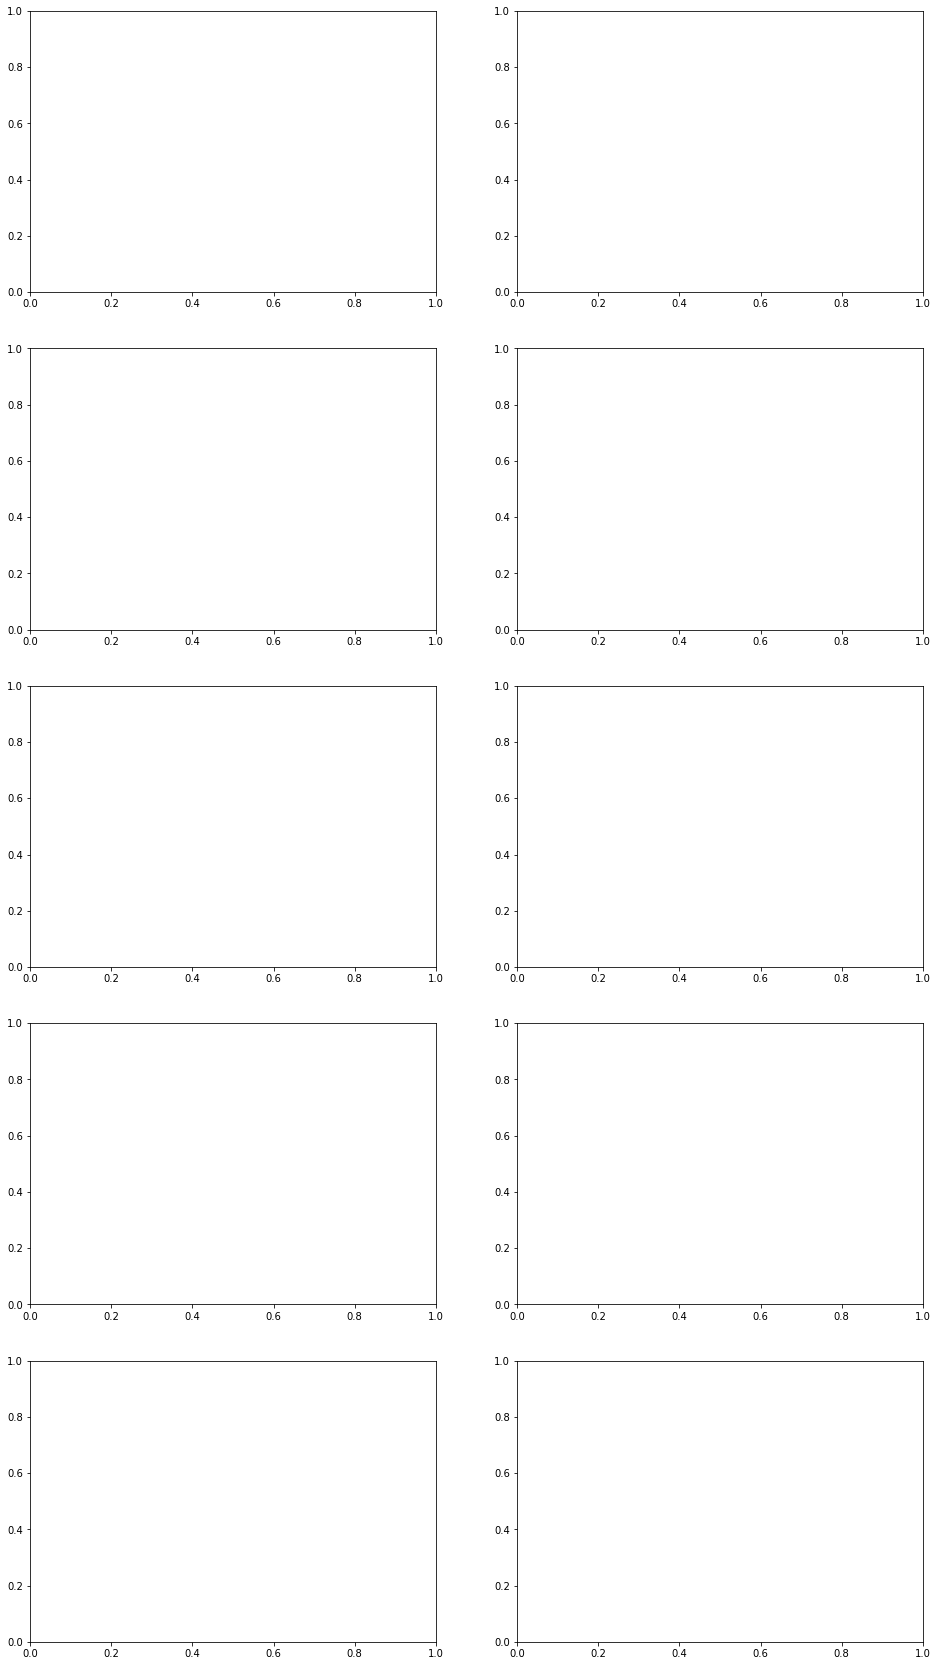

In [40]:
run_list=[0,1,2]
pval_list=[0.5,0.7,0.8,0.9,0.95,0.99]

main_enum=20
topic_name ="spurious"
topic_name_list = ["causal","spurious"]
sample=1000
noise=0.1
mvsel_mode_list=["acc","loss"] #acc,loss
dcf=0.0 #0.0,0.5,1.0


plot_item_list=[
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/nlp_toy3/nlp_logs/cad.moulis1toy3.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).dcf({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8*2,6*(len(plot_item_list)+2)]
fig,ax = plt.subplots(len(plot_item_list)+2,2)


for topic_name in topic_name_list:
    for midx,mvsel_mode in enumerate(mvsel_mode_list):
        plot_mouli_te_variation_with_pval(ax=ax[:,midx],
                                          run_list=run_list,
                                          pval_list=pval_list,
                                          main_enum=main_enum,
                                          plot_item_list = plot_item_list,
                                          fname_pattern = fname_pattern.format(
                                                                            "{1}",
                                                                            topic_name,
                                                                            sample,
                                                                            noise,
                                                                            "{0}",
                                                                            dcf,
                                                                            mvsel_mode,
                                          ),
                                          title="selection_mode={}".format(mvsel_mode),
                                          label_prefix=topic_name+"_",
        )
plt.show()

## Plotting the metric used for model selection in Mouli

model:()			 score:-28.586995442708314
model:('causal',)			 score:-6.365336100260379
model:('spurious',)			 score:-41.33529663085943
model:('causal', 'spurious')			 score:-33.16595458984375
Initial Edge List:[], initial score:-33.16595458984375
Starting the addition phase
Candidate topic:causal	 score:-41.33529663085943
Candidate topic:spurious	 score:-6.365336100260379

Adding edge: causal
Score after adding edge: -41.33529663085943
Candidate topic:spurious	 score:-28.586995442708314
Starting the removal phase
Candidate topic:causal	 score:-33.16595458984375
Final Invariance List: ('spurious',)
---------------------------------------------------------------------
pval: 0.5
selected invariance list:  ('spurious',)
---------------------------------------------------------------------







model:()			 score:-34.64692179361981
model:('causal',)			 score:-10.6595458984375
model:('spurious',)			 score:-39.343404134114564
model:('causal', 'spurious')			 score:-35.20725504557299
Initial Edge

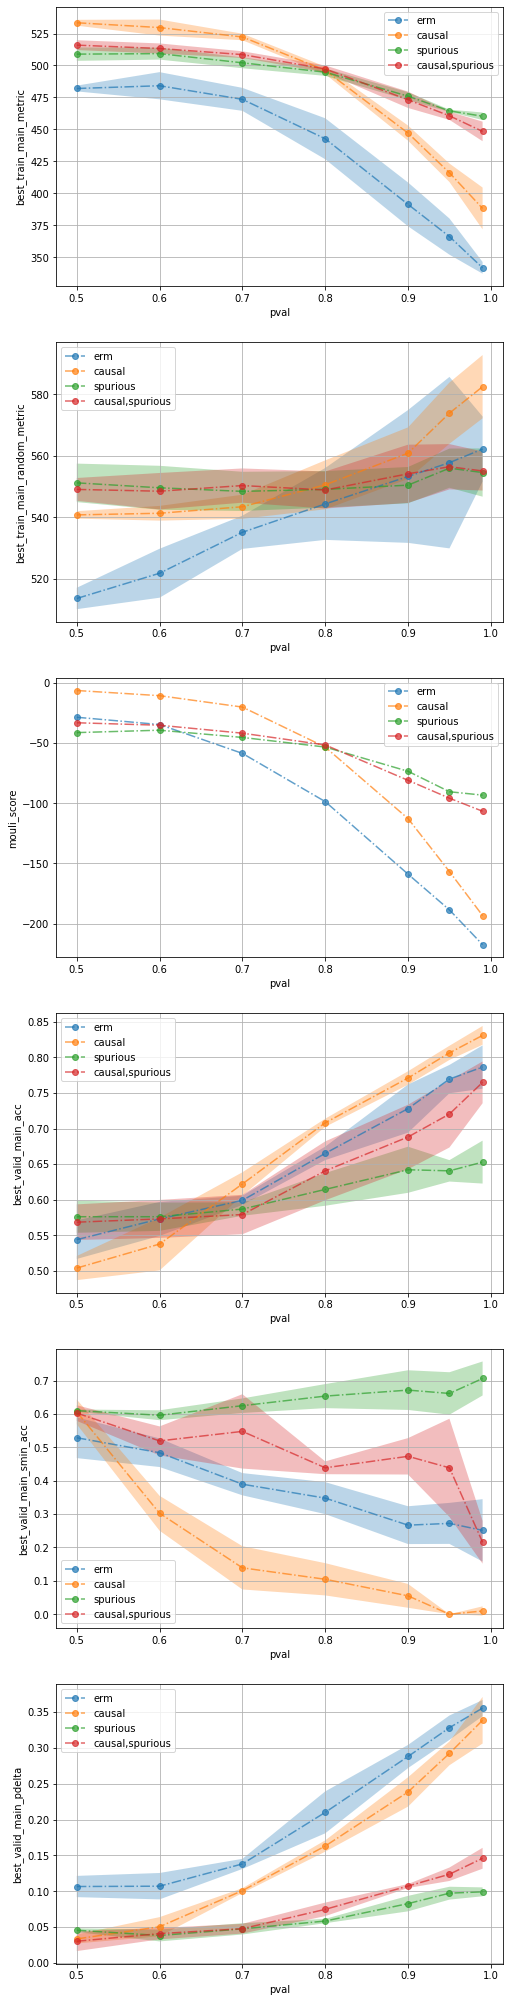

In [19]:
run_list=[0,1,2]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.95,0.99]

main_enum=20
topic_name_list = ["causal","spurious"]
topic_name_in_fname = "all"
sample=1000
noise=0.0
mvsel_mode="loss"
dcf=1.0 #0.0,0.5,1.0


mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
            "best_valid_main_smin_acc",
            "best_valid_main_pdelta",
]

probe_plot_item_list = [
]


fname_pattern = "dataset/nlp_toy3/nlp_logs/cad.moulis1toy3.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).dcf({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8,6*(len(mouli_plot_item_list+probe_plot_item_list))]
fig,ax = plt.subplots(len(mouli_plot_item_list+probe_plot_item_list),)


avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     fname_pattern=fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    dcf,
                                                                    mvsel_mode,
                                                  )
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict.keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()

# MNIST34 dataset

model:()			 score:-1612.41552734375
model:('color',)			 score:-1620.248291015625
model:('rotation',)			 score:-1615.706298828125
model:('color', 'rotation')			 score:-1620.826904296875
Initial Edge List:[], initial score:-1620.826904296875
Starting the addition phase
Candidate topic:color	 score:-1615.706298828125
Candidate topic:rotation	 score:-1620.248291015625
Starting the removal phase
Final Invariance List: ('color', 'rotation')
---------------------------------------------------------------------
pval: 0.5
selected invariance list:  ('color', 'rotation')
---------------------------------------------------------------------







model:()			 score:-1599.61376953125
model:('color',)			 score:-1624.77001953125
model:('rotation',)			 score:-1618.09765625
model:('color', 'rotation')			 score:-1617.4267578125
Initial Edge List:[], initial score:-1617.4267578125
Starting the addition phase
Candidate topic:color	 score:-1618.09765625
Candidate topic:rotation	 score:-1624.77001953125

A

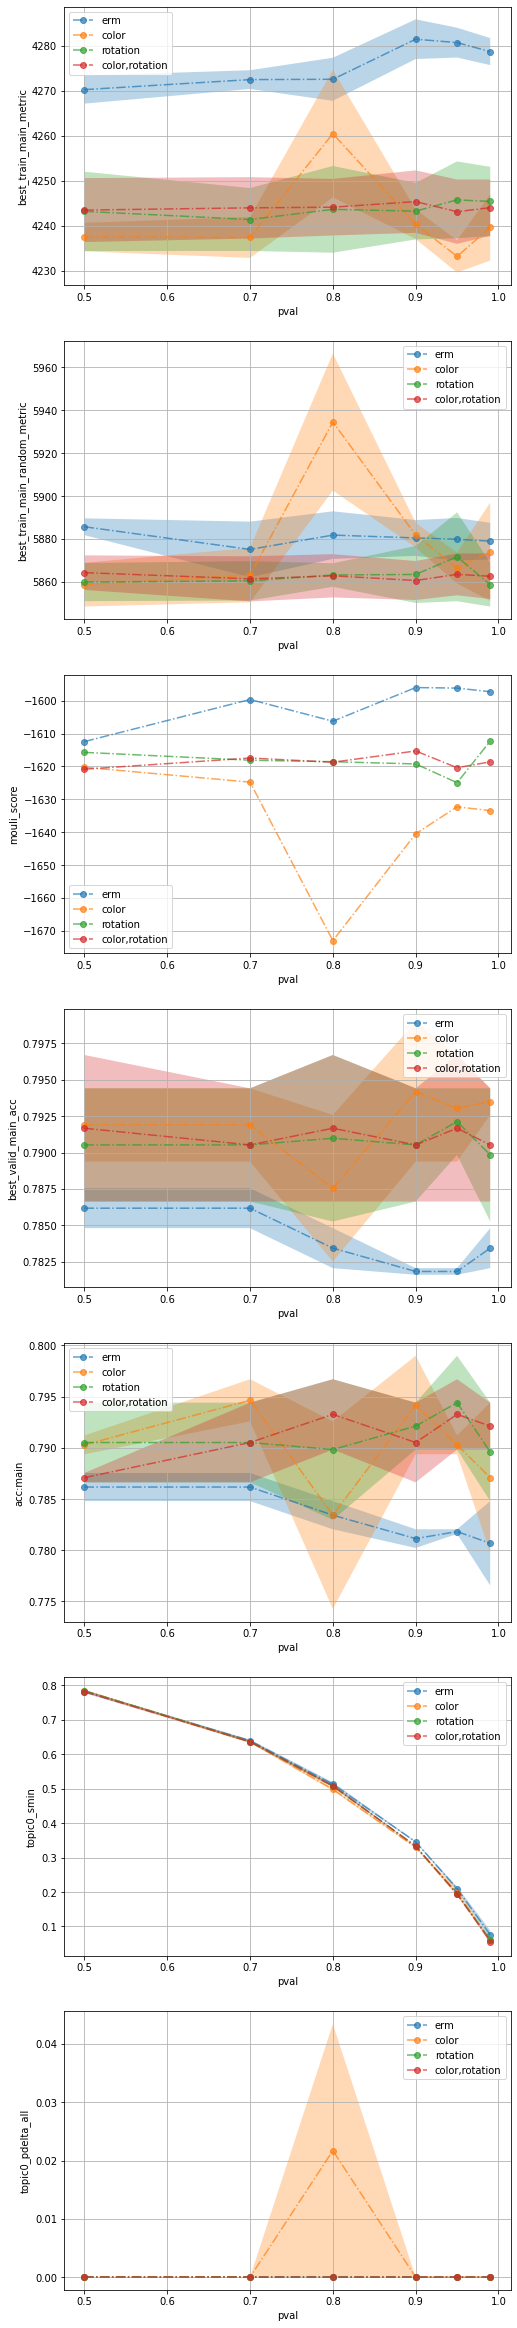

Bad pipe message: %s [b'c$\xdaP\x01`\xd4\xe3\x19G\x8fVm\xce~\x0c\xd1\x07 \xbe\x8f4\x91\xd6!\x01\x9b\x8d\x00\xe2\x8f-\x95\xe8\x99\xa7\xed\xd3\n\x0fZ\xc8\x1e\xcbr\xcc\xf9X\x98\xfa;\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 N6\x90$\xe7\xc6,\xbf\x9ep\xa6\x0c']
Bad pipe message: %s [b"\x1e\xb8\xfaJA\xd9CSM\xcb\x01\xddE\\\xb4\x19\x07\x90\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x

In [24]:
run_list=[1,2]
pval_list=[0.5,0.7,0.8,0.9,0.95,0.99]

main_enum=1
topic_name_list = ["color","rotation"]
topic_name_in_fname = "all"
sample=10000
noise=0.2
mvsel_mode="loss"
dcf=0.0 #0.0,0.5,1.0


mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
]


probe_plot_item_list = [
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/mnist/nlp_logs/cad.moulis1mnist.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).dcf({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8,6*(len(mouli_plot_item_list+probe_plot_item_list))]
fig,ax = plt.subplots(len(mouli_plot_item_list+probe_plot_item_list),)


avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     fname_pattern=fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    dcf,
                                                                    mvsel_mode,
                                                  )
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict.keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()

# CivilComments dataset

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/civilcomments/nlp_logs/cad.moulis1civil.rnum(0).topic(race).sample(5000).noise(0.0).pval(0.5).mvsel(acc)/probe_metric_list_erm.json'

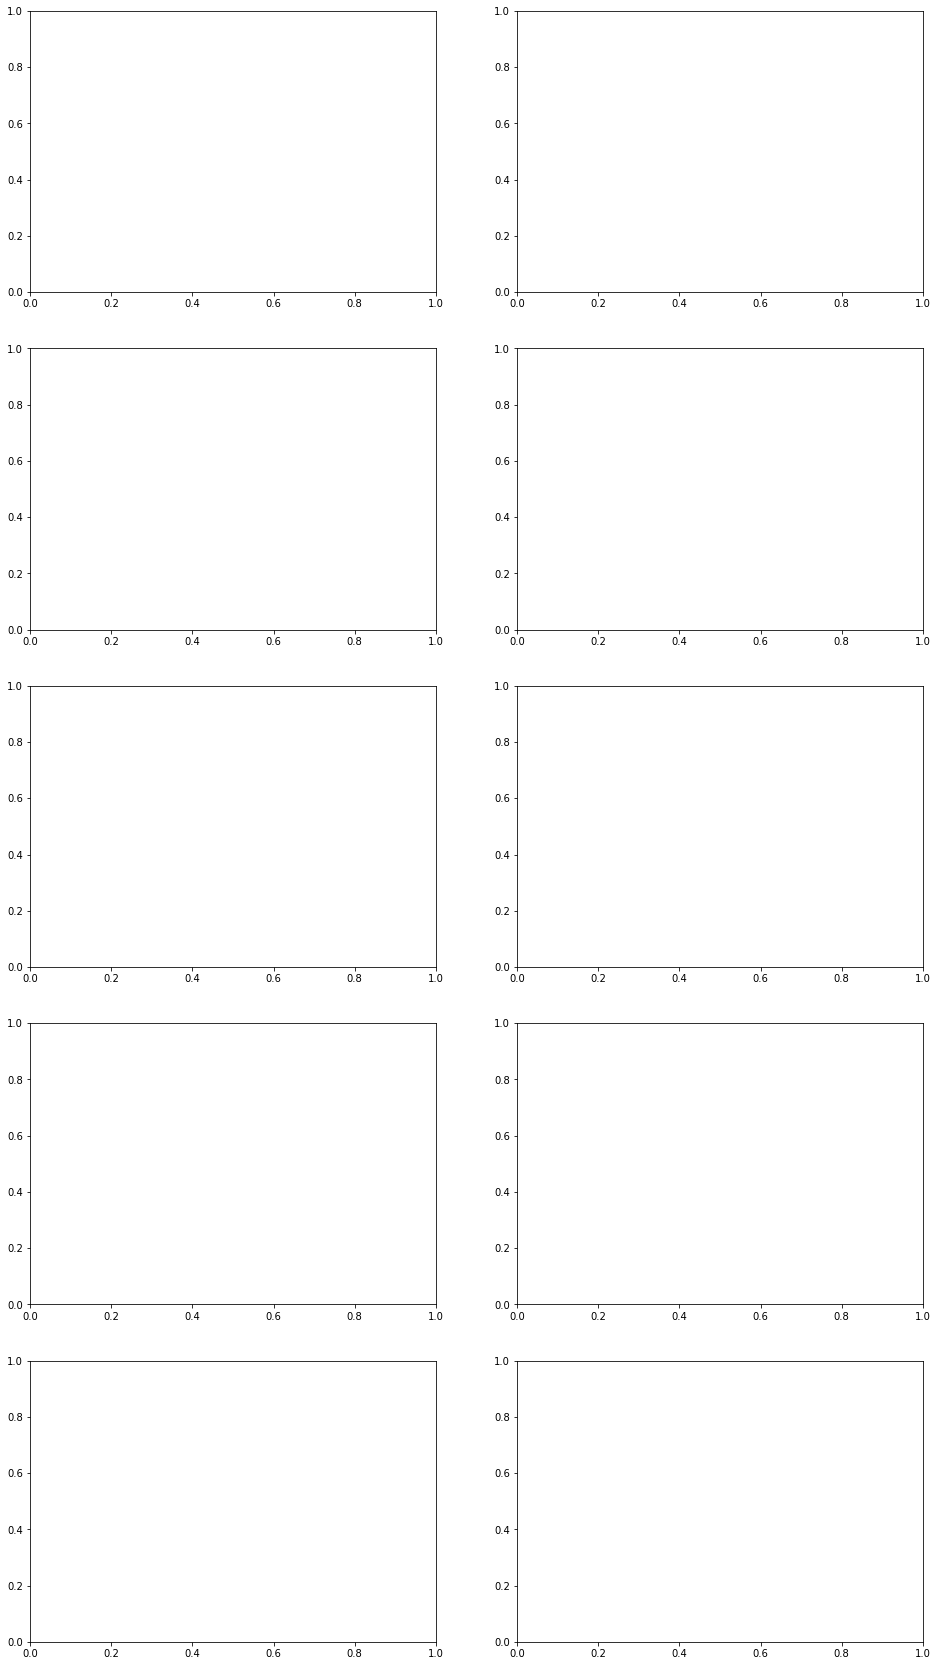

In [122]:
run_list=[0,1,2]
pval_list=[0.5,0.7,0.8,0.9,0.99]

main_enum=20
topic_name ="race"
sample=5000
noise=0.0
mvsel_mode_list=["acc","loss"] #acc,loss


plot_item_list=[
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/civilcomments/nlp_logs/cad.moulis1civil.rnum({}).topic({}).sample({}).noise({}).pval({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8*2,6*(len(plot_item_list)+2)]
fig,ax = plt.subplots(len(plot_item_list)+1,2)


for midx,mvsel_mode in enumerate(mvsel_mode_list):
    plot_mouli_te_variation_with_pval(ax=ax[:,midx],
                                      run_list=run_list,
                                      pval_list=pval_list,
                                      main_enum=main_enum,
                                      plot_item_list = plot_item_list,
                                      fname_pattern = fname_pattern.format(
                                                                        "{1}",
                                                                        topic_name,
                                                                        sample,
                                                                        noise,
                                                                        "{0}",
                                                                        mvsel_mode,
                                      ),
                                      title="selection_mode={}".format(mvsel_mode),
    )
plt.show()

# AAE dataset

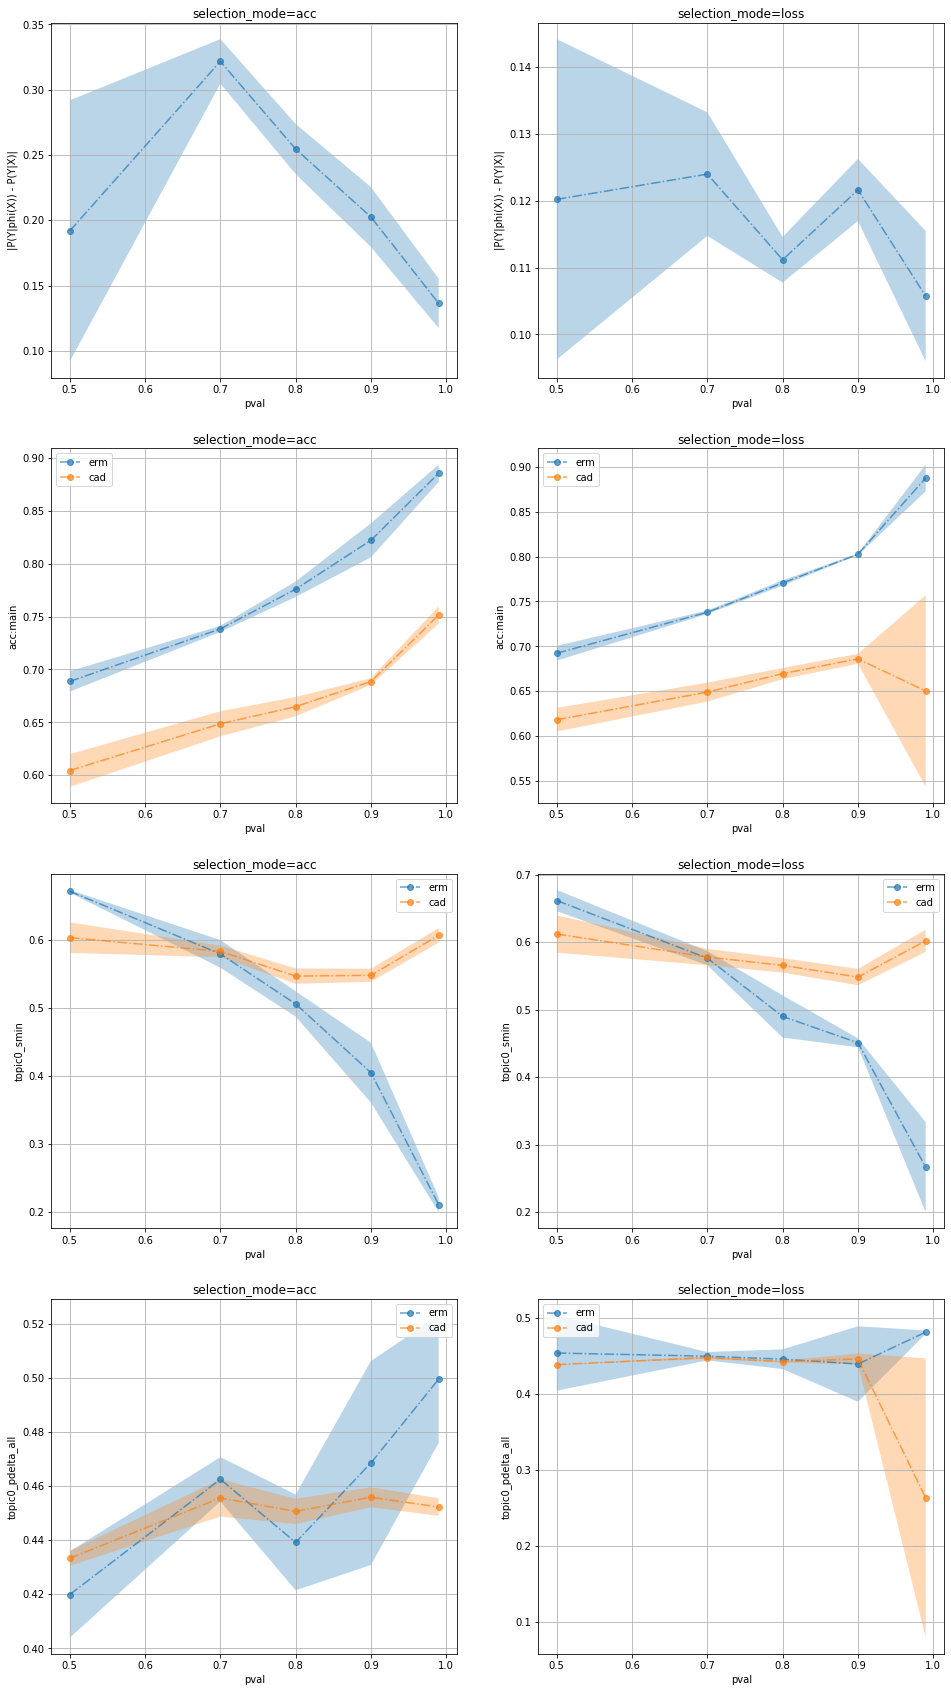

In [133]:
run_list=[1,2,]
pval_list=[0.5,0.7,0.8,0.9,0.99]

main_enum=20
topic_name ="race"
sample=10000
noise=0.0
mvsel_mode_list=["acc","loss"] #acc,loss


plot_item_list=[
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/twitter_aae_sentiment_race/nlp_logs/cad.moulis1aae.rnum({}).topic({}).sample({}).noise({}).pval({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8*2,6*(len(plot_item_list)+2)]
fig,ax = plt.subplots(len(plot_item_list)+1,2)


for midx,mvsel_mode in enumerate(mvsel_mode_list):
    plot_mouli_te_variation_with_pval(ax=ax[:,midx],
                                      run_list=run_list,
                                      pval_list=pval_list,
                                      main_enum=main_enum,
                                      plot_item_list = plot_item_list,
                                      fname_pattern = fname_pattern.format(
                                                                        "{1}",
                                                                        topic_name,
                                                                        sample,
                                                                        noise,
                                                                        "{0}",
                                                                        mvsel_mode,
                                      ),
                                      title="selection_mode={}".format(mvsel_mode),
    )
plt.show()